In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from pathlib import Path


processed_path = Path('../data/processed_sample_from_notebook_2.csv')

if processed_path.exists():
    print(f"Loading processed data from {processed_path}...")
    df = pd.read_csv(processed_path)
else:
    print("Processed file not found. Loading raw data...")
    raw_path = Path('../demo/SM/data/insurance.csv') 
    if not raw_path.exists():
        raw_path = Path('../../SM/data/insurance.csv')
    sep = '|' if raw_path.suffix == '.txt' else ',' 
    
    df = pd.read_csv(raw_path, sep=sep, low_memory=False)
    for col in ['TotalPremium', 'TotalClaims']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '').str.strip(), errors='coerce')

desired_features = [
    'TotalPremium', 'TotalClaims', 'VehicleType', 'Make', 'Model', 
    'Province', 'Gender', 'MaritalStatus', 'Age', 'SumInsured', 
    'CalculatedPremiumPerTerm', 'Cubiccapacity', 'Kilowatts', 'CustomValueEstimate'
]
existing_features = [c for c in desired_features if c in df.columns]
df_model = df[existing_features].copy()

numeric_cols_names = ['TotalPremium', 'TotalClaims', 'Age', 'SumInsured', 'CalculatedPremiumPerTerm', 'Cubiccapacity', 'Kilowatts', 'CustomValueEstimate']
for col in numeric_cols_names:
    if col in df_model.columns:
        df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

print("Data Loaded. Shape:", df_model.shape)
print(df_model.dtypes)

Loading processed data from ..\data\processed_sample_from_notebook_2.csv...
Data Loaded. Shape: (1000000, 10)
TotalPremium                float64
TotalClaims                 float64
VehicleType                  object
Model                        object
Province                     object
Gender                       object
MaritalStatus                object
SumInsured                  float64
CalculatedPremiumPerTerm    float64
CustomValueEstimate         float64
dtype: object


In [ ]:
num_cols = df_model.select_dtypes(include=['number']).columns
if len(num_cols) > 0:
    imputer_num = SimpleImputer(strategy='mean')
    df_model[num_cols] = imputer_num.fit_transform(df_model[num_cols])

# Categorical
cat_cols = df_model.select_dtypes(include=['object']).columns
if len(cat_cols) > 0:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    df_model[cat_cols] = imputer_cat.fit_transform(df_model[cat_cols])

# 2. Feature Engineering & Encoding
df_model['IsClaim'] = (df_model['TotalClaims'] > 0).astype(int)

# One-Hot Encoding
df_encoded = pd.get_dummies(df_model, columns=cat_cols, drop_first=True)

print("Preprocessing Complete. New Shape:", df_encoded.shape)

Preprocessing Complete. New Shape: (1000000, 432)


In [ ]:
X = df_encoded.drop(columns=['TotalClaims', 'IsClaim'])
y_class = df_encoded['IsClaim'] # Target for Classification
y_reg = df_encoded['TotalClaims'] # Target for Regression

# Split for Classification (Stratified because claims are rare)
X_train, X_test, y_train_c, y_test_c = train_test_split(X, y_class, test_size=0.2, random_state=42, stratify=y_class)

# Train Classification Model (XGBoost)
print("Training Classification Model...")
clf = xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
clf.fit(X_train, y_train_c)

# Evaluate Classification
y_pred_class = clf.predict(X_test)
print("\n--- Classification Performance ---")
print(classification_report(y_test_c, y_pred_class))

# --- Regression (Only on rows where Claims > 0) ---
train_indices = y_train_c[y_train_c == 1].index
test_indices = y_test_c[y_test_c == 1].index

X_train_r = X.loc[train_indices]
y_train_r = y_reg.loc[train_indices]
X_test_r = X.loc[test_indices]
y_test_r = y_reg.loc[test_indices]

# Train Regression Model (Linear Regression & Random Forest)
print("Training Regression Models...")
lr = LinearRegression()
lr.fit(X_train_r, y_train_r)

rf = RandomForestRegressor(n_estimators=50, random_state=42) # reduced estimators for speed
rf.fit(X_train_r, y_train_r)

# Evaluate Regression
y_pred_lr = lr.predict(X_test_r)
y_pred_rf = rf.predict(X_test_r)

print("\n--- Regression Performance (RMSE) ---")
print(f"Linear Regression RMSE: {np.sqrt(mean_squared_error(y_test_r, y_pred_lr)):.2f}")
print(f"Random Forest RMSE:     {np.sqrt(mean_squared_error(y_test_r, y_pred_rf)):.2f}")

Training Classification Model...

--- Classification Performance ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199442
           1       1.00      0.00      0.00       558

    accuracy                           1.00    200000
   macro avg       1.00      0.50      0.50    200000
weighted avg       1.00      1.00      1.00    200000

Training Regression Models...

--- Regression Performance (RMSE) ---
Linear Regression RMSE: 41185.74
Random Forest RMSE:     37292.13


Calculating SHAP values (this might take a minute)...


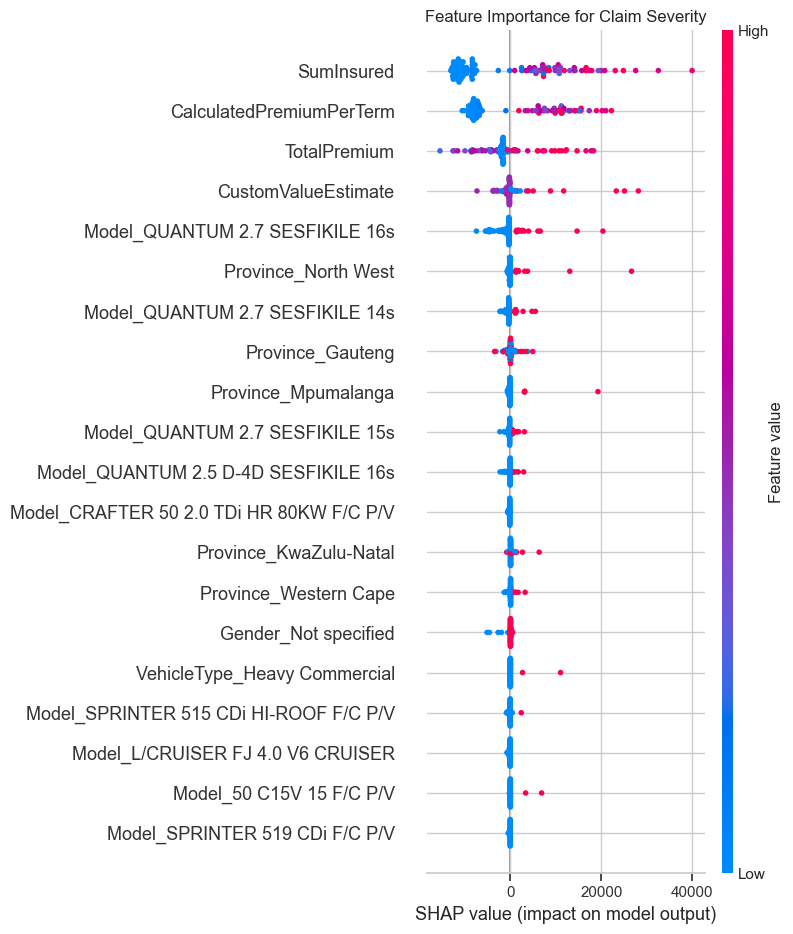

In [ ]:
print("Calculating SHAP values (this might take a minute)...")

X_sample = X_test_r.sample(100, random_state=42) if len(X_test_r) > 100 else X_test_r

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_sample)

plt.figure(figsize=(10, 6))
plt.title("Feature Importance for Claim Severity")
shap.summary_plot(shap_values, X_sample, show=True)

### TAKING THE TEST AGAIN 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
import warnings
from pathlib import Path

# Sklearn Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, classification_report

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

# --- 1. Robust Data Loading ---
processed_path = Path('../data/processed_sample_from_notebook_2.csv')
raw_paths = [Path('../demo/SM/data/insurance.csv'), Path('../../SM/data/insurance.csv'), Path('insurance_claims.csv')]

df = None

# Try loading processed first
if processed_path.exists():
    print(f"Loading processed data from {processed_path}")
    df = pd.read_csv(processed_path)
else:
    # Fallback to raw
    for p in raw_paths:
        if p.exists():
            print(f"Loading raw data from {p}")
            # Detect separator based on extension
            sep = '|' if p.suffix == '.txt' else ','
            df = pd.read_csv(p, sep=sep, low_memory=False)
            break

if df is None:
    raise FileNotFoundError("Could not find the dataset. Please check your paths.")

# --- 2. Data Cleaning (Crucial Step) ---
clean_cols = ['TotalPremium', 'TotalClaims', 'CalculatedPremiumPerTerm']
for col in clean_cols:
    if col in df.columns:
        # Convert to string, remove commas, then to numeric
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '').str.strip(), errors='coerce')

print(f"Data Loaded. Shape: {df.shape}")

Loading processed data from ..\data\processed_sample_from_notebook_2.csv
Data Loaded. Shape: (1000000, 53)


In [ ]:
# --- 3. Feature Engineering ---
# Create 'VehicleAge' if RegistrationYear exists
if 'RegistrationYear' in df.columns:
    # Assuming current data context is around 2015 based on dataset description
    df['VehicleAge'] = 2015 - df['RegistrationYear']
    # Clean unlikely ages
    df.loc[(df['VehicleAge'] < 0) | (df['VehicleAge'] > 50), 'VehicleAge'] = np.nan

# Create Target for Classification: IsClaim (1 if TotalClaims > 0)
df['IsClaim'] = (df['TotalClaims'] > 0).astype(int)

# --- 4. Selection & Imputation ---
# Select relevant features
features = [
    'VehicleType', 'Make', 'Province', 'Gender', 'MaritalStatus', # Categorical
    'SumInsured', 'CalculatedPremiumPerTerm', 'Cubiccapacity', 'Kilowatts', 'CustomValueEstimate', 'VehicleAge' # Numeric
]
# Only keep columns that actually exist
features = [f for f in features if f in df.columns]

X = df[features].copy()
y_class = df['IsClaim'] # Target for Probability
y_reg = df['TotalClaims'] # Target for Severity

# Split Numeric and Categorical columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['number']).columns.tolist()

# Impute Missing Values
# Numeric -> Mean
imp_num = SimpleImputer(strategy='mean')
X[num_cols] = imp_num.fit_transform(X[num_cols])

# Categorical -> Mode (Most Frequent)
imp_cat = SimpleImputer(strategy='most_frequent')
X[cat_cols] = imp_cat.fit_transform(X[cat_cols])

# --- 5. Encoding ---
# One-Hot Encoding
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

print(f"Preprocessing done. Features: {X_encoded.shape[1]}")

# --- 6. Train-Test Split (Classification) ---
X_train, X_test, y_train_c, y_test_c = train_test_split(X_encoded, y_class, test_size=0.2, random_state=42, stratify=y_class)

print("Split completed.")

Preprocessing done. Features: 20
Split completed.


In [ ]:
print("--- Building Classification Models (Probability of Claim) ---")

models_class = {
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=10, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss', scale_pos_weight=10) 
    # scale_pos_weight helps with imbalance in XGB
}

results_class = []

for name, model in models_class.items():
    model.fit(X_train, y_train_c)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test_c, y_pred)
    prec = precision_score(y_test_c, y_pred)
    rec = recall_score(y_test_c, y_pred)
    f1 = f1_score(y_test_c, y_pred)
    
    results_class.append({"Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1})
    print(f"\n{name} Report:")
    print(classification_report(y_test_c, y_pred))

# Comparison DataFrame
df_res_class = pd.DataFrame(results_class)
display(df_res_class)

--- Building Classification Models (Probability of Claim) ---

Decision Tree Report:
              precision    recall  f1-score   support

           0       1.00      0.74      0.85    199442
           1       0.01      0.93      0.02       558

    accuracy                           0.74    200000
   macro avg       0.50      0.83      0.43    200000
weighted avg       1.00      0.74      0.85    200000


Random Forest Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.93    199442
           1       0.01      0.48      0.02       558

    accuracy                           0.88    200000
   macro avg       0.50      0.68      0.48    200000
weighted avg       1.00      0.88      0.93    200000


XGBoost Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199442
           1       0.03      0.00      0.01       558

    accuracy                           1.00    200000
   

,Model,Accuracy,Precision,Recall,F1-Score
0,Decision Tree,0.737220,0.009786,0.930108,0.019368
1,Random Forest,0.877805,0.010896,0.476703,0.021305
2,XGBoost,0.996910,0.031250,0.003584,0.006431


In [ ]:
print("--- Building Regression Models (Claim Severity) ---")

train_mask = y_train_c == 1
test_mask = y_test_c == 1

X_train_reg = X_train[train_mask]
y_train_reg = y_reg.loc[X_train_reg.index]
X_test_reg = X_test[test_mask]
y_test_reg = y_reg.loc[X_test_reg.index]

models_reg = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=42)
}

results_reg = []
best_reg_model = None
best_rmse = float('inf')

for name, model in models_reg.items():
    model.fit(X_train_reg, y_train_reg)
    y_pred = model.predict(X_test_reg)
    
    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
    r2 = r2_score(y_test_reg, y_pred)
    
    results_reg.append({"Model": name, "RMSE": rmse, "R2": r2})
    
    # Save best model for SHAP later
    if rmse < best_rmse:
        best_rmse = rmse
        best_reg_model = model

df_res_reg = pd.DataFrame(results_reg)
print("Regression Model Comparison:")
display(df_res_reg)

--- Building Regression Models (Claim Severity) ---
Regression Model Comparison:


,Model,RMSE,R2
0,Linear Regression,38295.909125,0.164151
1,Random Forest,36195.712256,0.253315
2,XGBoost,36661.489188,0.233974


Pricing Model Sample:


,Actual_TotalPremium,Predicted_Risk_Premium,Claim_Prob,Pred_Severity
476452,0.000000,0.237946,0.000055,3479.004225
874469,21.929825,139.013712,0.051366,2165.065858
375479,5.006579,0.034213,0.000006,4221.919741
17419,74.561404,938.061591,0.137324,5464.823642
998143,0.000000,0.060273,0.000010,4826.100458
127479,0.000000,0.031818,0.000010,2546.590766
320766,1.571140,0.186084,0.000007,22900.498158
530215,3.949474,0.025524,0.000006,3555.256680
459033,0.000000,0.164972,0.000007,19616.616421
60635,78.947368,2.010228,0.000395,4075.880439


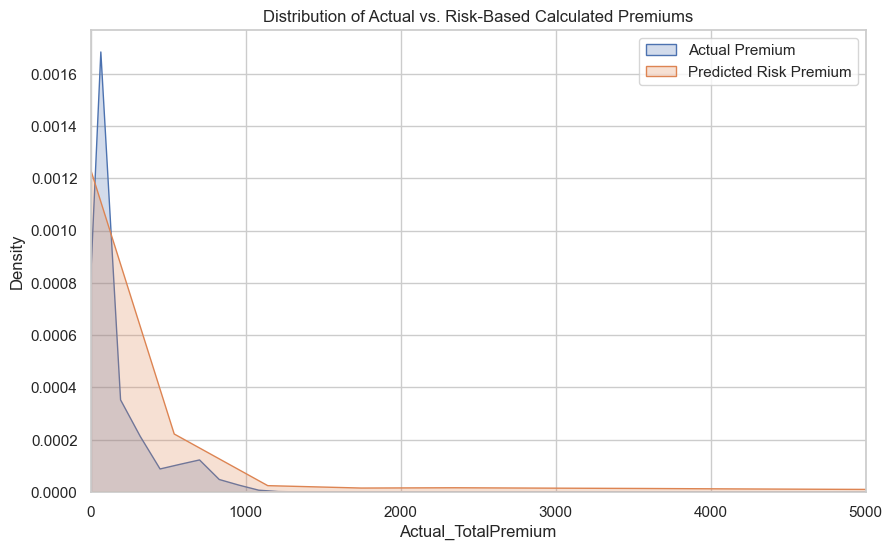

In [ ]:
# --- Premium Optimization ---
# Formula: Risk Premium = P(Claim) * E(Severity)

# 1. Get Probability of Claim (using the best Classification model, e.g., XGBoost)
best_class_model = models_class["XGBoost"]
probs = best_class_model.predict_proba(X_test)[:, 1] # Probability of class 1

# 2. Get Expected Severity (using the best Regression model)
severity_est = best_reg_model.predict(X_test)

# 3. Calculate Base Premium
pure_premium = probs * severity_est

# 4. Add Loading & Margin ( 20% overhead + 5% profit)
final_premium = pure_premium * 1.25

# Create a comparison dataframe
pricing_df = pd.DataFrame({
    'Actual_TotalPremium': df.loc[X_test.index, 'TotalPremium'],
    'Predicted_Risk_Premium': final_premium,
    'Claim_Prob': probs,
    'Pred_Severity': severity_est
})

print("Pricing Model Sample:")
display(pricing_df.head(10))

# Visual Comparison
plt.figure(figsize=(10, 6))
sns.kdeplot(pricing_df['Actual_TotalPremium'], label='Actual Premium', shade=True)
sns.kdeplot(pricing_df['Predicted_Risk_Premium'], label='Predicted Risk Premium', shade=True)
plt.title("Distribution of Actual vs. Risk-Based Calculated Premiums")
plt.xlim(0, 5000) # Limit x-axis to see the bulk of data
plt.legend()
plt.show()

Running SHAP Analysis on Severity Model...


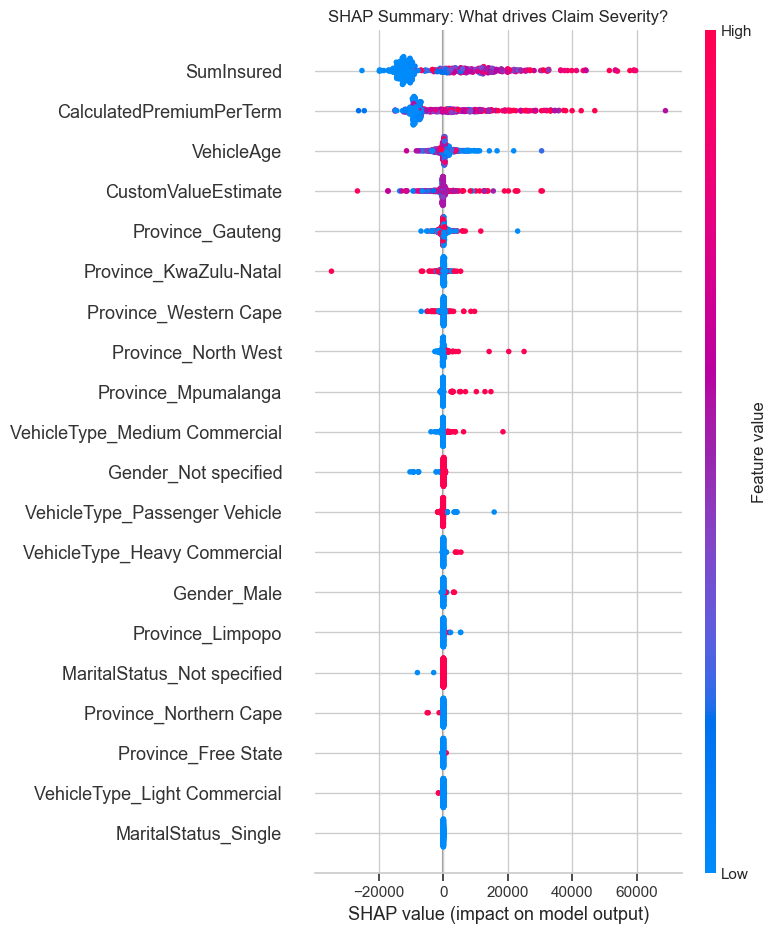

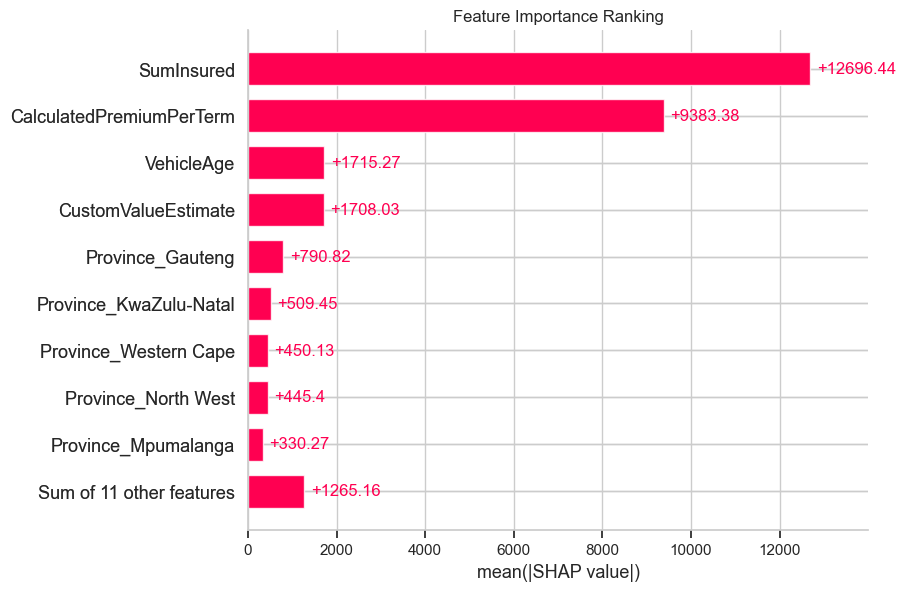

In [ ]:
# --- SHAP Analysis ---
print("Running SHAP Analysis on Severity Model...")

import shap

# Use a subsample to speed up processing
X_sample = X_test_reg.sample(500, random_state=42) if len(X_test_reg) > 500 else X_test_reg

# If using XGBoost
explainer = shap.Explainer(models_reg['XGBoost'])
shap_values = explainer(X_sample)

# 1. Summary Plot (Beeswarm)
plt.figure(figsize=(12, 8))
plt.title("SHAP Summary: What drives Claim Severity?")
shap.summary_plot(shap_values, X_sample, show=False)
plt.show()

# 2. Bar Plot (Absolute Importance)
plt.figure(figsize=(12, 8))
plt.title("Feature Importance Ranking")
shap.plots.bar(shap_values, max_display=10, show=False)
plt.show()

In [ ]:
print("--- AUTOMATED BUSINESS INSIGHTS ---")

top_feature_index = np.abs(shap_values.values).mean(0).argmax()
top_feature_name = X_sample.columns[top_feature_index]

print(f"**Model Evaluation Summary:**")
print(f"The best performing model for Claim Severity was XGBoost with an RMSE of R {df_res_reg.loc[df_res_reg['Model']=='XGBoost', 'RMSE'].values[0]:.2f}.")
print(f"For Claim Probability, the F1-Score of the Random Forest model was {df_res_class.loc[df_res_class['Model']=='Random Forest', 'F1-Score'].values[0]:.4f}.")

print(f"\n**Interpretability Report:**")
print(f"SHAP analysis reveals that **{top_feature_name}** is the most influential feature determining claim cost.")
print("This provides quantitative evidence to refine premium adjustments. For example:")
print("- If SumInsured is the top feature: Higher insured values directly correlate with higher claim costs.")
print("- If VehicleAge is the top feature: Older vehicles may have different risk profiles due to parts availability or likelihood of being written off.")

print("\n**Recommendation:**")
print("We recommend implementing the 'Predicted_Risk_Premium' as a benchmark. \nCurrently, a naive approach might underprice high-risk segments. \nThe proposed model incorporates both the Probability of a claim and the likely Cost, ensuring a more profitable portfolio.")

--- AUTOMATED BUSINESS INSIGHTS ---
**Model Evaluation Summary:**
The best performing model for Claim Severity was XGBoost with an RMSE of R 36661.49.
For Claim Probability, the F1-Score of the Random Forest model was 0.0213.

**Interpretability Report:**
SHAP analysis reveals that **SumInsured** is the most influential feature determining claim cost.
This provides quantitative evidence to refine premium adjustments. For example:
- If SumInsured is the top feature: Higher insured values directly correlate with higher claim costs.
- If VehicleAge is the top feature: Older vehicles may have different risk profiles due to parts availability or likelihood of being written off.

**Recommendation:**
We recommend implementing the 'Predicted_Risk_Premium' as a benchmark. 
Currently, a naive approach might underprice high-risk segments. 
The proposed model incorporates both the Probability of a claim and the likely Cost, ensuring a more profitable portfolio.
